# Is random imputation always better than deterministic imputation?
According to Gelman & Hill Data Analysis Using Regression and Multilevel/Hierarchical Models, chapter 25.4 it is good to add noise with standard deviation of the residual to not falsely assume deterministic imputation, and use random imputation instead. My intuition is that although the distribution of imputed variable $x$ might be a better approximation of the true distribution of the true (non-missing) $x$, this is not always a good idea. The problem that the noise introduced is totally uncorrelated with outcome $x$ and therefore biasing your estimate $\beta$ towards 0, similar to measurement error bias / attenuation bias / regression dilution.

In [117]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install pandas

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import seaborn as sns
import pandas as pd

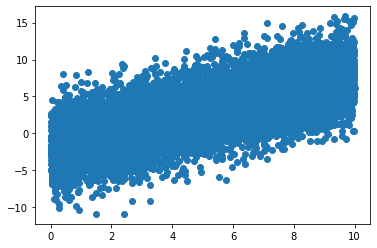

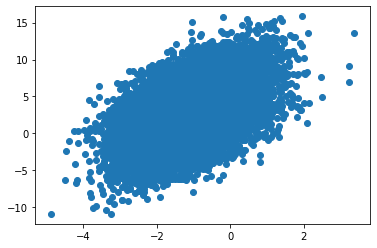

In [119]:
beta_0 = 0
beta_1 = 1
beta_2 = 2
b1_b2 = -1
n = 10000
stdev_noise = 2
stdev_noise_b1_b2 = 1
noise = np.random.normal(0, stdev_noise, n)
c = np.ones(n)
x_1 = np.random.uniform(0,10, n)
# x_2 = np.random.normal(b1_b2*x_1, stdev_noise_b1_b2, n)  ## used to show confounding
x_2 = np.random.normal(b1_b2, stdev_noise_b1_b2, n)
y = c * beta_0 + x_1 * beta_1 + x_2 * beta_2 + noise
y = y.reshape((-1,1))
X = np.c_[c, x_1, x_2]
plt.scatter(x_1,y)
plt.show()
plt.scatter(x_2,y)

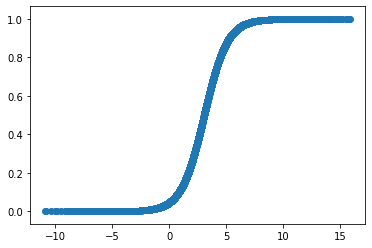

In [120]:
# amount_of_dependancy_missing_on_y = 4
# y_scaled = (y - np.mean(y)) / np.std(y) * amount_of_dependancy_missing_on_y
# plt.scatter(y,scipy.stats.logistic.cdf(y_scaled))

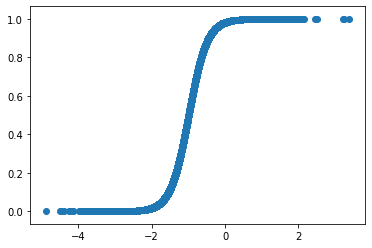

In [121]:
## note used to show that missing at random when controlling for x2 isn't a problem
amount_of_dependancy_missing_on_x2 = 4
x2 = X[:,2].copy()
x2_scaled = (x2 - np.mean(x2)) / np.std(x2) * amount_of_dependancy_missing_on_x2
plt.scatter(x2,scipy.stats.logistic.cdf(x2_scaled))

In [133]:
probability_missing = np.mean(scipy.stats.logistic.cdf(x2_scaled))
print(probability_missing)
missing = np.random.binomial(1,probability_missing, n)
Xmissing_random = pd.DataFrame(X.copy())
Xmissing_random[1][missing==1] = np.NaN

missing = np.random.binomial(1,scipy.stats.logistic.cdf(x2_scaled))
Xm = pd.DataFrame(X.copy())
Xm[1][missing.flatten()==1] = np.NaN
print(np.mean(y[missing.flatten()==1]))
print(np.mean(y[missing.flatten()==0]))

0.4999352216743865
4.447634684737789
1.6539043193901972


### Results with the real data (no missing values)

In [123]:
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                 1.565e+04
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:17:17   Log-Likelihood:                -21045.
No. Observations:               10000   AIC:                         4.210e+04
Df Residuals:                    9997   BIC:                         4.212e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0588      0.045     -1.318      0.1

### Results with the real data ommitting $x_2$ (no missing values)

In [124]:
mod = sm.OLS(y, X[:,0:2])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                 1.064e+04
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:17:17   Log-Likelihood:                -24513.
No. Observations:               10000   AIC:                         4.903e+04
Df Residuals:                    9998   BIC:                         4.905e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0177      0.057    -35.601      0.0

### with $x_1$ missing completely at random

In [125]:
mod = sm.OLS(y[~Xmissing_random[1].isna()], Xmissing_random[~Xmissing_random[1].isna()])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     7508.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:17:17   Log-Likelihood:                -10401.
No. Observations:                4920   AIC:                         2.081e+04
Df Residuals:                    4917   BIC:                         2.083e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0245      0.064      0.380      0.7

### with the probability of missing $x_1$ depending on $x_2$

In [126]:
mod = sm.OLS(y[~Xm[1].isna()], Xm[~Xm[1].isna()])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     6561.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:17:17   Log-Likelihood:                -10611.
No. Observations:                5018   AIC:                         2.123e+04
Df Residuals:                    5015   BIC:                         2.125e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0138      0.092     -0.149      0.8

In [141]:
mod = sm.OLS(y[~Xm[1].isna()], Xm.loc[~Xm[1].isna(), 0:1])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     7371.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:39:31   Log-Likelihood:                -11416.
No. Observations:                4962   AIC:                         2.284e+04
Df Residuals:                    4960   BIC:                         2.285e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -3.5460      0.070    -50.947      0.0

### Note: this doesn't seem to be biased

### make a model to predict $x_1$ based on $x_2$ for imputing

In [128]:
mod = sm.OLS(Xm[1][~Xm[1].isna()], Xm[2][~Xm[1].isna()])
result = mod.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      1   R-squared (uncentered):                   0.651
Model:                            OLS   Adj. R-squared (uncentered):              0.651
Method:                 Least Squares   F-statistic:                              9344.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):                        0.00
Time:                        13:17:17   Log-Likelihood:                         -13327.
No. Observations:                5018   AIC:                                  2.666e+04
Df Residuals:                    5017   BIC:                                  2.666e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Estimate using deterministic imputation

In [129]:
x_to_impute = result.predict(Xm[2][Xm[1].isna()])
Ximputed = Xm.copy()
Ximputed[1][Xm[1].isna()] = x_to_impute.copy()

mod = sm.OLS(y, Ximputed)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     3848.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:17:17   Log-Likelihood:                -25284.
No. Observations:               10000   AIC:                         5.057e+04
Df Residuals:                    9997   BIC:                         5.060e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              4.5074      0.044    102.916      0.0

### Now do random imputation

In [130]:
x_to_impute = result.predict(Xm[2][Xm[1].isna()]) \
            + np.random.normal(0, np.power(result.mse_resid,0.5), len(y[Xm[1].isna()]))
Ximputed = Xm.copy()
Ximputed[1][Xm[1].isna()] = x_to_impute.copy()

mod = sm.OLS(y, Ximputed)
res2 = mod.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     2534.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:17:17   Log-Likelihood:                -26088.
No. Observations:               10000   AIC:                         5.218e+04
Df Residuals:                    9997   BIC:                         5.220e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              4.7899      0.047    102.123      0.0

### the bias in $\beta_1$ seems to be getting worse!
### findings:
* when not directly depending on $y$ but on ommitted variable $x_2$, we don't really see the bias, which is strange
* especially the impact is not large in comparison with the impact of true confounding
* from the potential outcomes model this makes sense: problems occur when $Y_1$ and $Y_0$ are different between treatment and control. Intuitively, with missing / non-missing we only have a problem when $Y_1$ and $Y_0$ are different. 
* My explanation is that because the underlying data generating model is linear, we don't see any bias. However, when the effect is non-linear and the overlap in data for treated and non-treated is limited there will be a problem. This non-overlap might well be created or made worse by missing variables.
* imputation seems to make results worse, so if you don't have good reason I won't do it. Also, it might be better to do propensity score matching / inverse propensity weighting. When there is some overlap this should be able to balance the data, without creating the regression dilution.
* random imputation seems to make it even worse

### Appendix: using the method for adding a variable for missingness

In [131]:
Xcorrected = Xm.copy()
Xcorrected[1][Xm[1].isna()] = 0
Xcorrected['missing'] = 0
Xcorrected.loc[Xm[1].isna(), 'missing'] = 1

mod = sm.OLS(y, Xcorrected)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     3343.
Date:                Sat, 19 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:17:18   Log-Likelihood:                -24664.
No. Observations:               10000   AIC:                         4.934e+04
Df Residuals:                    9996   BIC:                         4.937e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1553      0.109     -1.425      0.1